In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow -q
!pip install keras -q

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Library for reading and showing images
import matplotlib.image as mpimg

# Importing the sub-modules from TensorFlow and Keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator #I had to change this because it changed in TensorFlow 2.x
from tensorflow.keras.utils import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# Importing libraries to deploy model through a REST API
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import uvicorn

In [9]:
parent_dir = '/content/drive/MyDrive/5. Datasets/X-Ray Pneumonia/cut'

splits = ['train', 'val', 'test']
labels = ['pneumonia', 'normal']

for split in splits:
    for label in labels:
        var_name = f'path_{split}_{label}'
        globals()[var_name] = os.path.join(parent_dir, split, label.upper()) #para hacer el label mayúsculo y que encuentre el directorio, pero que el nombre del string no sea en mayúsculas
        print(var_name)

path_train_pneumonia
path_train_normal
path_val_pneumonia
path_val_normal
path_test_pneumonia
path_test_normal


In [10]:
# Get a list of filenames for images in the "Pneumonia" dirs
train_torax_pneumonia = os.listdir(path_train_pneumonia)
train_torax_normal = os.listdir(path_train_normal)
test_torax_pneumonia = os.listdir(path_test_pneumonia)
test_torax_normal = os.listdir(path_test_normal)
val_torax_pneumonia = os.listdir(path_val_pneumonia)
val_torax_normal = os.listdir(path_val_normal)

In [11]:
# This is a list of the filenames for the images in the "Pneumonia" and "Normal" training dir
train_torax_pneumonia = os.listdir(path_train_pneumonia)
train_torax_normal = os.listdir(path_train_normal)

In [12]:
train_torax_pneumonia[:8]

['person260_bacteria_1222.jpeg',
 'person266_bacteria_1244.jpeg',
 'person267_virus_552.jpeg',
 'person267_bacteria_1250.jpeg',
 'person265_virus_548.jpeg',
 'person264_bacteria_1233.jpeg',
 'person26_bacteria_122.jpeg',
 'person26_bacteria_126.jpeg']

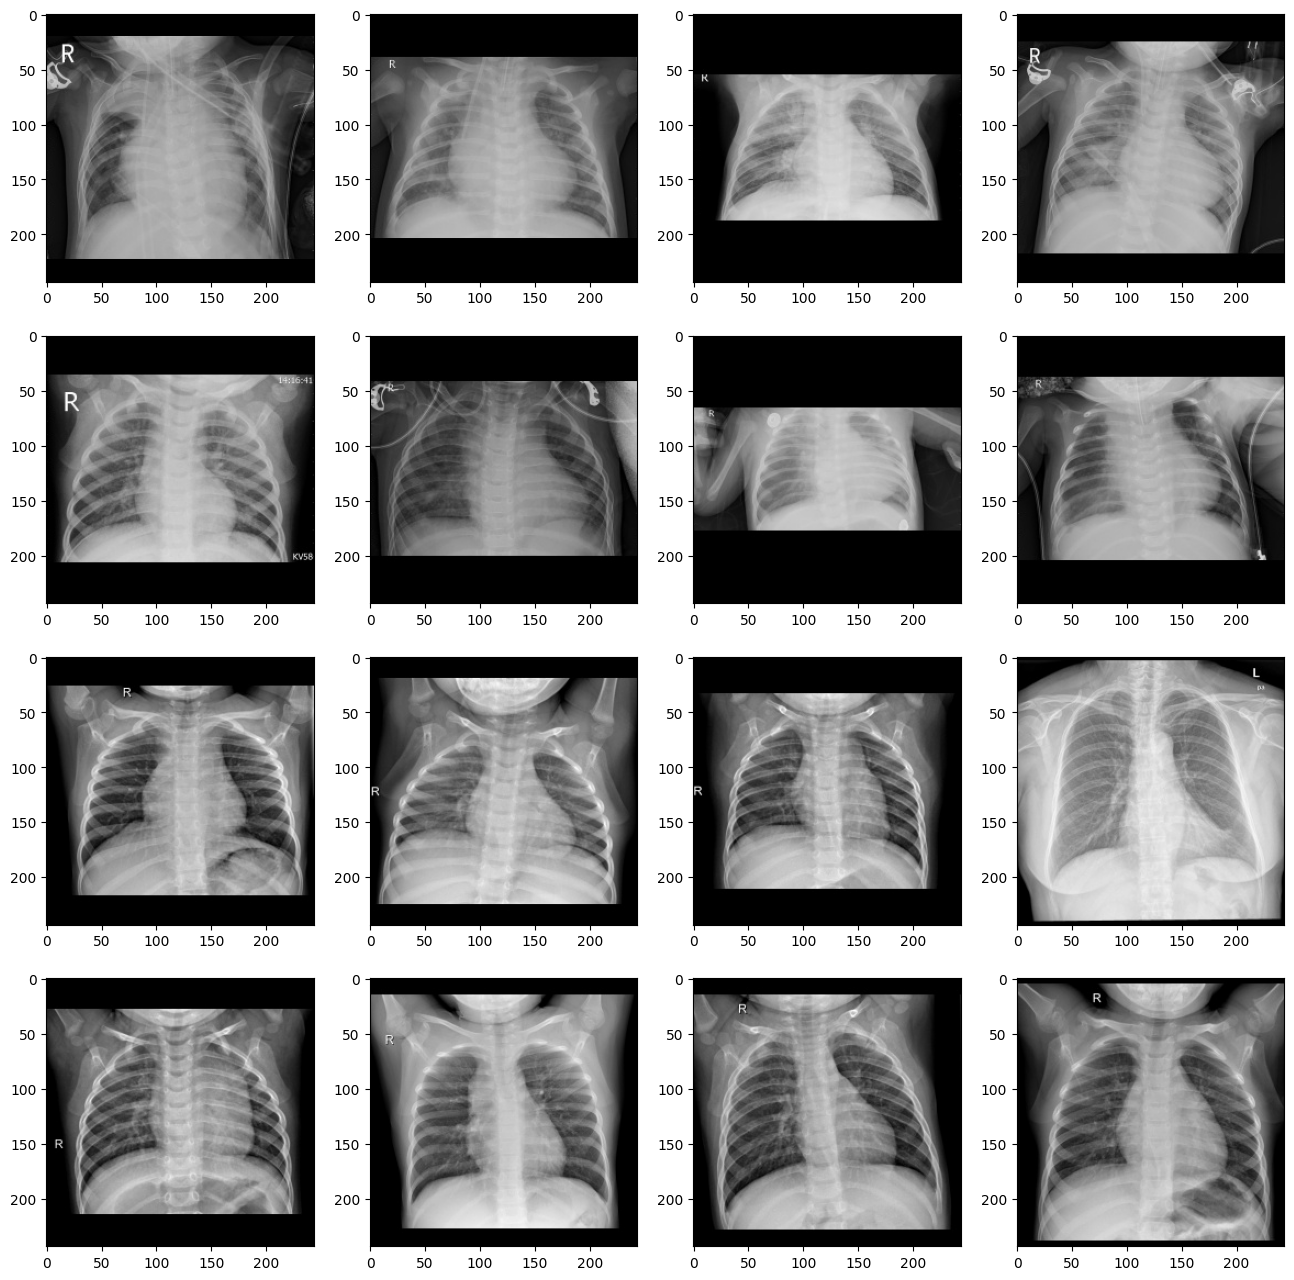

In [15]:
# Create a figure for displaying images, setting the figure size to 16x8 inches
fig = plt.figure(figsize=(16, 8))

# Adjust the figure size to ensure clarity in visualization
fig.set_size_inches(16, 16)

#This is to create the full file paths for the first 8 images in the "pneumonia" directory
#This means: join the paths created above, over a loop of file names that are contained in a list
img_file_paths_pneumonia = [os.path.join(path_train_pneumonia, file_name) for file_name in train_torax_pneumonia[:8]]
img_file_paths_normal = [os.path.join(path_train_normal, file_name) for file_name in train_torax_normal[:8]]

# Loop through the combined list of image paths from both categories (16 images in total)
for i, img_path in enumerate(img_file_paths_pneumonia + img_file_paths_normal): #How does i know how far to go? Because it's based on the length of the combined list
    # Create a subplot (4 rows, 4 columns) and position it at (i+1)
    ax = plt.subplot(4, 4, i + 1) # i is used to place the image into the correct spot in the 4×4 grid:

    # Remove axis labels for better visualization
    ax.axis('On')

    # Load and display the image from the given path
    img = mpimg.imread(img_path)
    plt.imshow(img)

# Display the figure with all the selected images
plt.show()

In [16]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.1,
                              width_shift_range=0.1,
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.1)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

train_folder = os.path.join(parent_dir, 'train')
validation_folder = os.path.join(parent_dir, 'val')


# Flowing training images in batches of 64 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    batch_size=64,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

# Flowing testing images in batches of 64 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_folder,
                                                         batch_size=64,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


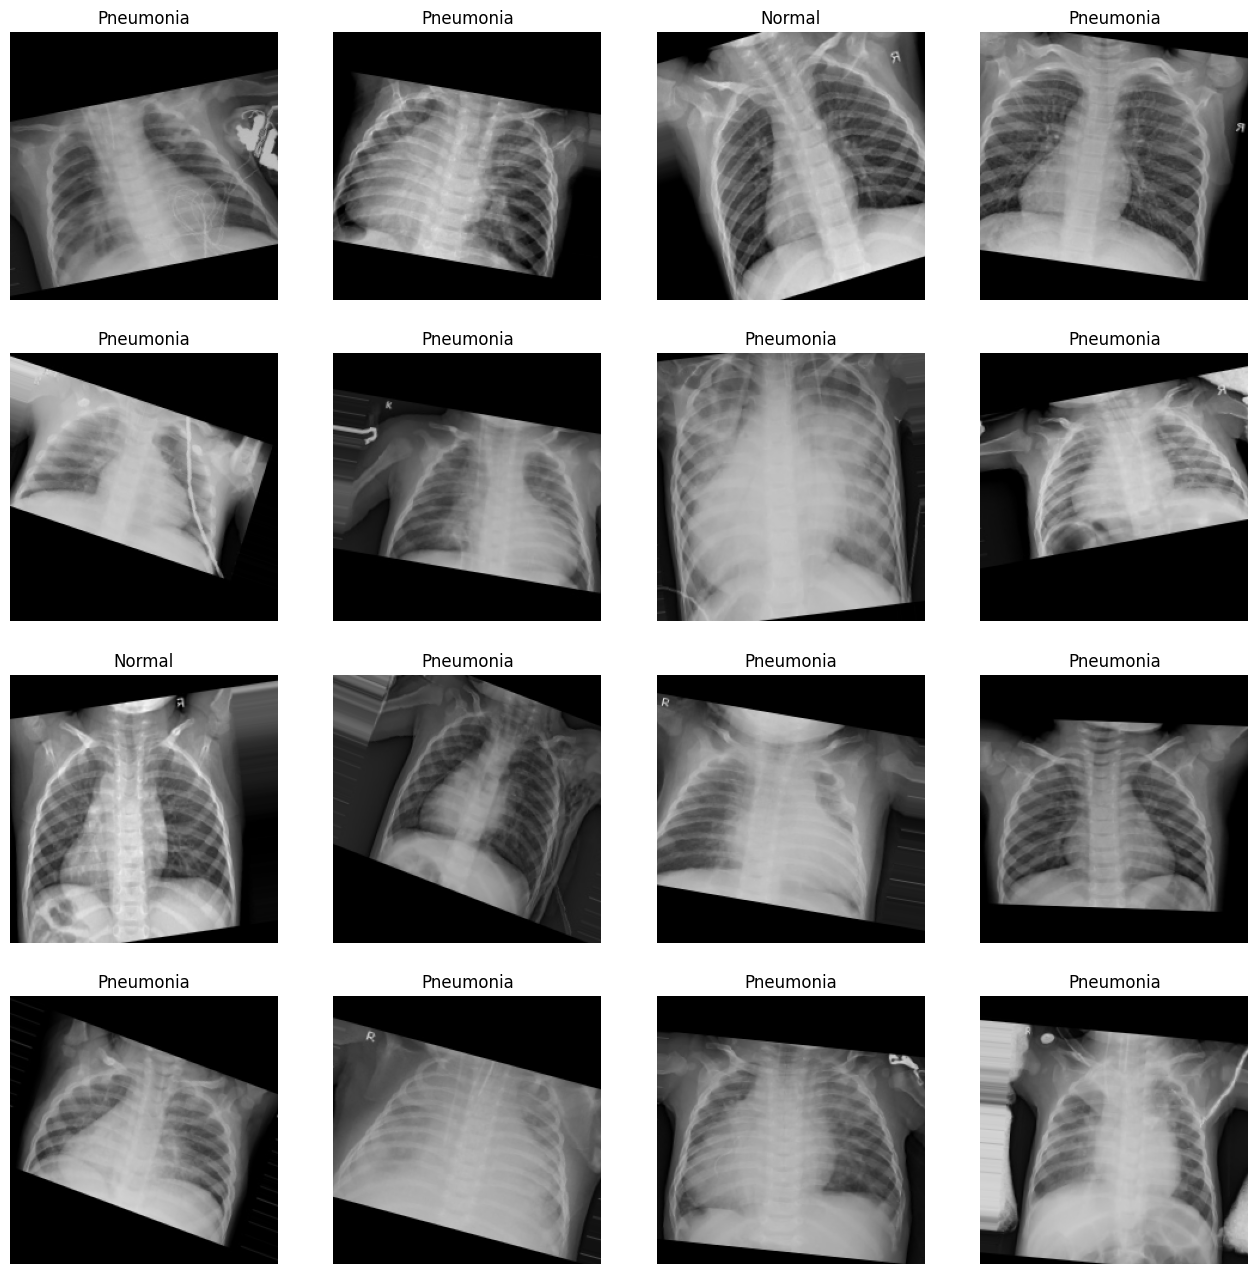

In [17]:
images, labels = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label == 1:
        ax.set_title('Pneumonia')
    else:
        ax.set_title('Normal')
    ax.axis('off')

## **CNN Model from scratch**

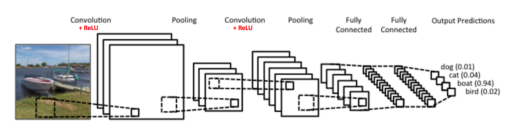

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/content/drive/MyDrive/5. Datasets/X-Ray Pneumonia/CNN.png')
plt.imshow(img)
plt.axis('off')  # hides axes
plt.show()

In [19]:
cnn_model = Sequential()
#First layer of convolutions:
cnn_model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D(2, 2))
cnn_model.add(BatchNormalization())  # Normalize activations to stabilize and accelerate training

#Second layer of convolutions:
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(2, 2))
cnn_model.add(BatchNormalization())

#Third layer of convolutions:
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(2, 2))

#Fourth lay of convolutions:
cnn_model.add(Conv2D(16, (3, 3), activation='relu'))

#Vectorize the image:
cnn_model.add(Flatten())

#Prediction layers with Fully connected NN:
#Fully connected layer with 64 neurons:
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25)) # Randomly disables a fraction of neurons during training to prevent overfitting (25%).

#Fully connected layer with 32 neurons NN:
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.25))

#One more fully connected layer with 32 neurons NN:
cnn_model.add(Dense(32, activation='relu'))

# Output layer for binary classification just like in logistic regression (1 unit + sigmoid)
cnn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# This code compiles and summarizes the CNN model:
# compile(): configures the model for training using:
#     'binary_crossentropy' as the loss function (used for binary classification)
#   - 'adam' optimizer (Adaptive Moment Estimation)
#   - 'accuracy' as the evaluation metric
#    - summary(): prints a summary of the model architecture, including layer types, output shapes, and parameter counts
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
cnn_model.summary()

#The memory size (3.21 MB) is an estimate based on how many bytes are needed to store all parameters (usually 4 bytes per float32).
#Breakdown of float32:

#A float32 value uses 32 bits (4 bytes) of memory, divided into:

 #  1 bit for the sign (positive or negative)
 #  8 bits for the exponent (range of the number)
 # 23 bits for the fraction/mantissa (precision)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 627,569 (2.39 MB)

 Trainable params: 627,377 (2.39 MB)

 Non-trainable params: 192 (768.00 B)

In [21]:
# Pulling a single large batch of random testing data for testing after each epoch
valX, valY = next(validation_generator)

In [ ]:
model_history = cnn_model.fit(train_generator,
                              validation_data=(valX, valY),
                              epochs=10)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2318s 28s/step - accuracy: 0.7499 - loss: 0.5495 - val_accuracy: 0.8125 - val_loss: 0.5303
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 80s 975ms/step - accuracy: 0.8430 - loss: 0.3350 - val_accuracy: 0.5000 - val_loss: 1.1543
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 80s 981ms/step - accuracy: 0.8960 - loss: 0.2516 - val_accuracy: 0.5000 - val_loss: 1.0973
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 986ms/step - accuracy: 0.9223 - loss: 0.2061 - val_accuracy: 0.5000 - val_loss: 0.8761
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 79s 964ms/step - accuracy: 0.9215 - loss: 0.2007 - val_accuracy: 0.5000 - val_loss: 1.2301
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 80s 973ms/step - accuracy: 0.9291 - loss: 0.1758 - val_accuracy: 0.5000 - val_loss: 1.1410
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 985ms/step - accuracy: 0.9388 - loss: 0.1628 - val_accuracy: 0.6250 - val_loss: 0.9821
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 80s 974ms/step - accuracy: 0.9488 - loss: 0.1417 - val_accu

In [22]:
# Function to plot loss, val_loss,
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")

In [ ]:
# Plotting the loss vs epoch curve for the basic CNN model without Transfer Learning
plot_history(model_history)

In [24]:
test_folder = os.path.join(parent_dir, 'test')

# Flowing testing images in batches of 64 using test_datagen generator
test_generator =  test_datagen.flow_from_directory(test_folder,
                                                         batch_size=64,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))


# Pulling a single large batch of random testing data for testing after each epoch
testX, testY = next(test_generator)

# Evaluating on the Test dataset
cnn_model.evaluate(test_generator)

Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step - accuracy: 0.6260 - loss: 0.6853


[0.6857475638389587, 0.625]

In [25]:
# (1) Predict for a single image input
def predict_single_image(model, img_path, target_size=(224, 224)):
    """
    Predicts the class of a single image.

    Args:
        model: Trained Keras model.
        img_path (str): Path to the image file.
        target_size (tuple): Target size for reshaping the image.

    Returns:
        float: Predicted probability for the positive class (pneumonia).
    """
    img_path = '/content/drive/MyDrive/5. Datasets/X-Ray Pneumonia/cut/train/NORMAL/IM-0117-0001.jpeg'

    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale like training data

    prediction = model.predict(img_array)
    return prediction[0][0]

# Example usage:
# Replace with the path to a single image you want to predict on
single_image_path = os.path.join(path_test_normal, test_torax_normal[0])
prediction = predict_single_image(cnn_model, single_image_path)

print(f"Prediction for {single_image_path}: {prediction}")
if prediction > 0.5:
    print("Predicted class: Pneumonia")
else:
    print("Predicted class: Normal")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Prediction for /content/drive/MyDrive/5. Datasets/X-Ray Pneumonia/cut/test/NORMAL/IM-0025-0001.jpeg: 0.5159317255020142
Predicted class: Pneumonia


# **CNN through transfer learning using VGG16**

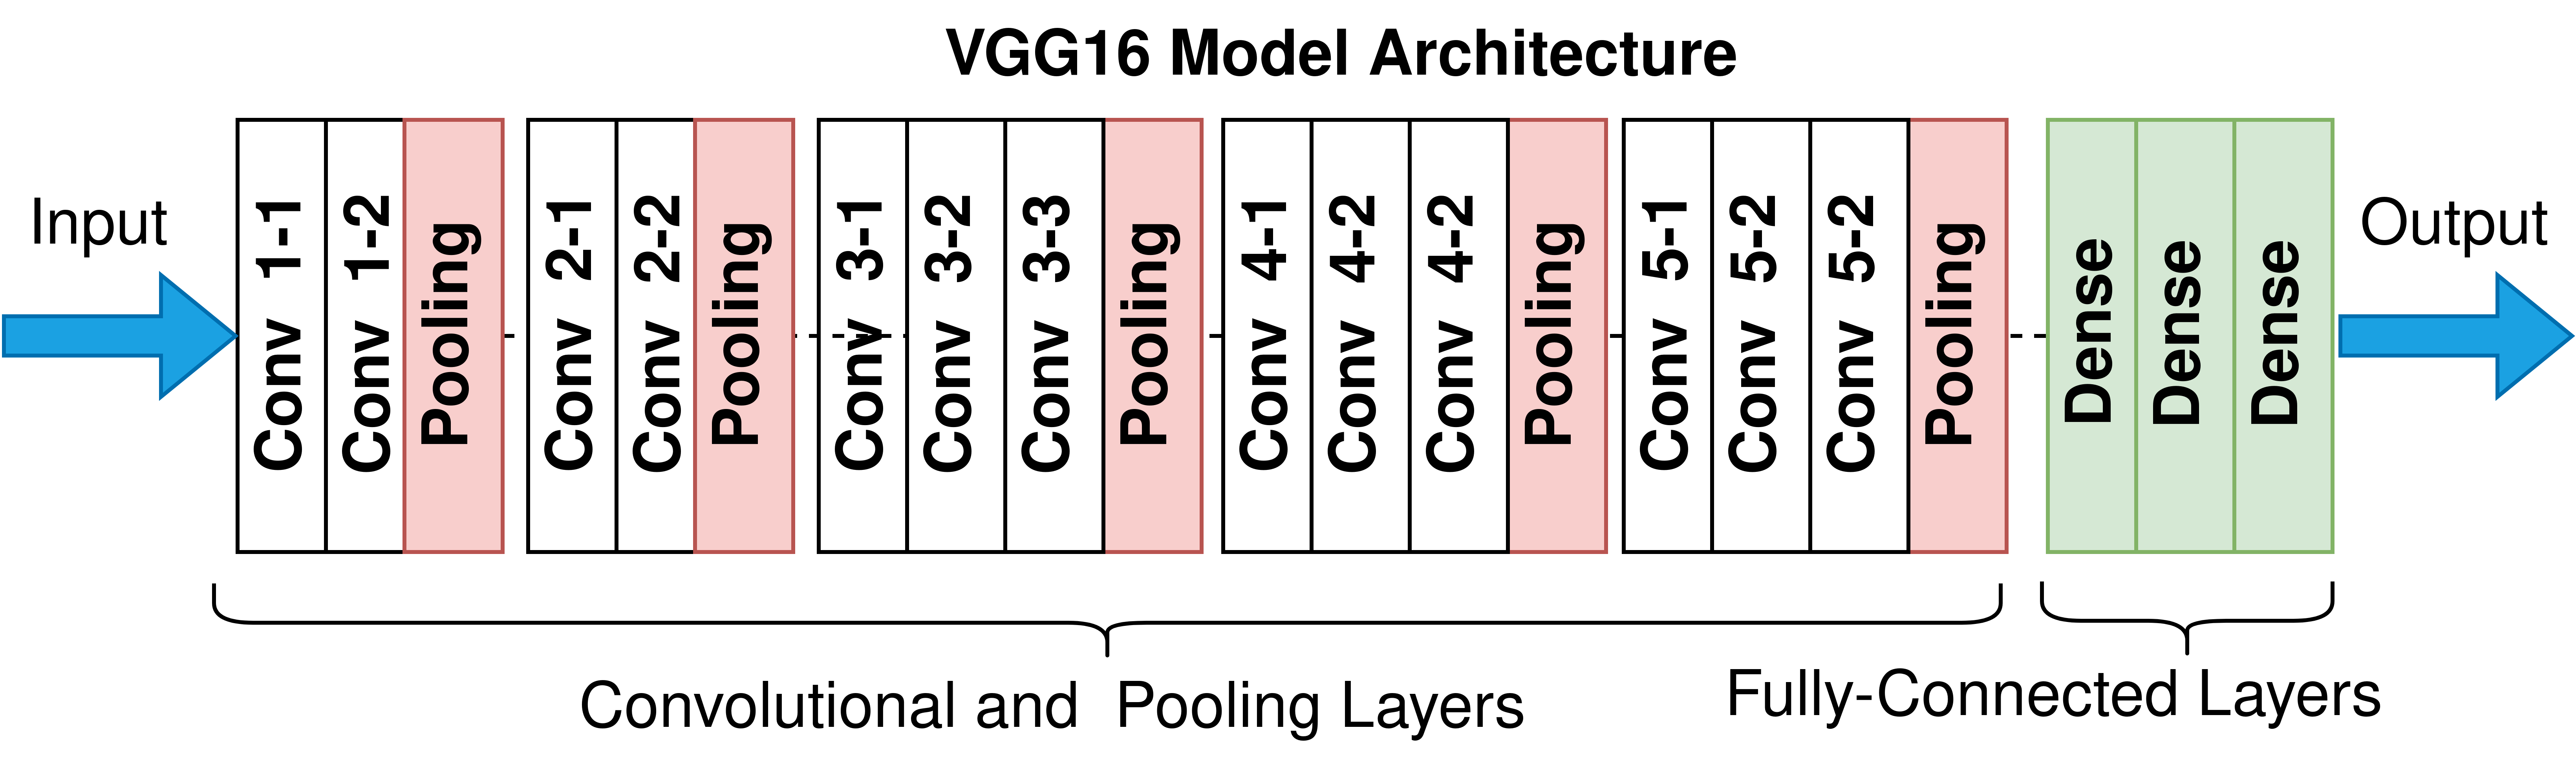

In [26]:
# Summary of the whole model
model = VGG16(weights='imagenet') #The VGG16 can be donwloaded from the internet and request it to provide the weights used in the ImageNet Competition
model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# The idea of transfer learning is that I can cut the architecture up to any given layer. Use those weights pre-estimated and then do my prediction for something esle
# Getting only the conv layers for transfer learning.
transfer_layer = model.get_layer('block5_pool') #block5_pool is the very last layer before the fully connected NN used for prediction
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [28]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [29]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [30]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

In [31]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_16 (Functional)      │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,518,625 (59.20 MB)

 Trainable params: 803,937 (3.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [41]:
## Fitting the VGG model
new_model_history = new_model.fit(train_generator,
                                  validation_data=(valX, valY),
                                  epochs=5)

Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 1179s 14s/step - accuracy: 0.8574 - loss: 0.3623 - val_accuracy: 0.9375 - val_loss: 0.1769
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 993ms/step - accuracy: 0.9517 - loss: 0.1202 - val_accuracy: 0.8125 - val_loss: 0.3729
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 997ms/step - accuracy: 0.9575 - loss: 0.1054 - val_accuracy: 0.8750 - val_loss: 0.2026
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 996ms/step - accuracy: 0.9682 - loss: 0.0838 - val_accuracy: 1.0000 - val_loss: 0.0817
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 996ms/step - accuracy: 0.9668 - loss: 0.0838 - val_accuracy: 0.8125 - val_loss: 0.3637


In [43]:
# Evaluating on the Test set
new_model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7984 - loss: 0.5856


[0.5484426617622375, 0.8012820482254028]

**Saving the model weights for deployment**

In [ ]:
# (1.1) Save the model h5
model_save_path = '/content/drive/MyDrive/5. Datasets/X-Ray Pneumonia/cnn_pneumonia_model.h5'
cnn_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/5. Datasets/X-Ray Pneumonia/cnn_pneumonia_model.h5


In [ ]:
# (1.2) Save the model to keras by libraries recommendation
model_save_path = '/content/drive/MyDrive/5. Datasets/X-Ray Pneumonia/cnn_pneumonia_model.keras' # Changed extension to .keras
cnn_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/5. Datasets/X-Ray Pneumonia/cnn_pneumonia_model.keras


In [44]:
# (2.1) Save the VGG16 prediction model to keras by libraries recommendation
model_save_path = '/content/drive/MyDrive/5. Datasets/X-Ray Pneumonia/cnn_pneumonia_model_VGG16.keras' # Changed extension to .keras
new_model.save(model_save_path)
print(f"Model VGG16 TL saved to {model_save_path}")

Model VGG16 TL saved to /content/drive/MyDrive/5. Datasets/X-Ray Pneumonia/cnn_pneumonia_model_VGG16.keras
